# CKD-Classification

This is an assignment given in the **Open University of Israel**'s course: **Data Mining**, in which I was asked to define the problem, preproccess the data, and solve the problem using classification algorithms.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz
import seaborn as sns
from sklearn import tree
from sklearn.tree import export_graphviz
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import DBSCAN
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc, homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score, log_loss, accuracy_score
from scipy.io.arff import loadarff
import random
import math
import warnings

warnings.filterwarnings('ignore')

## Defining the Problem

The purpose of the data mining process regarding **Chronic Kidney Disease** (CKDs) is to reveal patterns, dependencies or hidden meanings in the following set of features, describing people's health conditions. Using statistical tools, algorithms and models, we can check the influence of the given 24 attributes on the possibility of being diagnosed with CKD. This proccess will help us understand the factors affecting kidney disease, diagnose it earlier and suggest the best treatment method, or even prevent the disease in the future.

## Defining the Attributes

| # | Attribute name | Description | Data type | Unit measures | Range of values | Average | Standard deviation |
| - | -------------- | ---------- | --------- | -------------- | ------------------ | ------- | ------------------ |
| 1 | age | Age | numeric | years | 2-90 | 51.48338 | 17.16971 |
| 2 | bp | Blood pressure | numeric | Mm/Hg | 50-180 | 76.46907 | 13.68364 |
| 3 | sg | Specific gravity | nominal | | {1.005,1.010,1.015,1.020,1.025} | | |
| 4 | al | Albumin | nominal | | {0,1,2,3,4,5} | | |
| 5 | su | Sugar | nominal | | {0,1,2,3,4,5} | | |
| 6 | rbc | Red blood cells | nominal | | {Normal, Abnormal} | | |
| 7 | pc | Pus cell | nominal | | {Normal, Abnormal} | | |
| 8 | pcc | Puss cell clumps | nominal | | {Present, Not present} | | |
| 9 | ba | Bacteria | nominal | | {Present, Not present} | | |
| 10 | bgr | Blood glucose random | numeric | Mgs/Dl | 22-490 | 148.0365 | 72.28171 |
| 11 | bu | Blood urea | numeric | Mgs/Dl | 1.5-391 | 57.42572 | 50.50301 |
| 12 | sc | Serum creatinine | numeric | Mgs/Dl | 0.4-76 | 3.072454 | 5.741126 |
| 13 | sod | Sodium | numeric |mEq/L | 4.5-163 | 137.5288 | 10.40875 |
| 14 | pot | Potassium | numeric | mEq/L | 2.5-47 | 4.627244 | 3.19304 |
| 15 | hemo | Hemoglobin | numeric | Gms | 3.1-17.8 | 12.52644 | 2.912587 |
| 16 | pcv | Packed cell volume | numeric | | 9-54 | 38.8845 | 8.990105 |
| 17 | wc | White blood cell count | numeric | Cells/cumm | 2200-26400 | 8406.122 | 2944.474 |
|18 | rc | Red blood cell count | numeric | Millions/cmm | 2.1-8 | 4.707435 | 1.025323 |
| 19 | htn | Hypertension | nominal | | {yes, No} | | |
| 20 | dm | Diabetes mellitus | nominal | | {yes, No} | | |
| 21 | cad | Coronay artery disease | nominal | | {yes, No} | | |
| 22 | appet | Appetite | nominal | | {Good, Poor} | | |
| 23 | pe | Pedel edema | nominal | | {yes, No} | | |
| 24 | ane | Anemia | nominal | | {yes, No} | | |


In [2]:
k = 10 # 10-fold cross validation
data = loadarff('chronic_kidney_disease.arff')
df = pd.DataFrame(data[0])
columns = df.columns

## Defining the KDD Steps

- KDD: Knowledge discovery in databases

### Defining Data Mining Goals

Prediction of the presence of **CKD**, depending on different medical indices of a patient.

### Data Collection and Storage

The data is taken from a single dataset from Bangladesh, and therefore there is no need in integration from different sources.

### Data Cleaning

The data contains missing values, so we want to fix the dataset by deleting observations or filling those values with close values, or by smoothing. In this case, I chose to fill in missing values using mean (for continous values) and mode (for discrete values).

In [3]:
"data decoding"
nom_att = ['sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'class']

for att in nom_att:
    df[att] = df[att].str.decode('utf-8')

In [4]:
"missing values"
df[['htn','dm','cad','pe','ane']] = df[['htn','dm','cad','pe','ane']].replace(to_replace={'yes':1,'no':0, '?':np.nan}) # yes/no/? -> 1/0/NaN
df[['rbc', 'pc']] = df[['rbc', 'pc']].replace(to_replace={'abnormal':1,'normal':0, '?':np.nan}) # abnormal/normal/? -> 1/0/NaN 
df[['pcc', 'ba']] = df[['pcc', 'ba']].replace(to_replace={'present':1,'notpresent':0, '?':np.nan}) # present/notpresent/? -> 1/0/NaN
df[['appet']] = df[['appet']].replace(to_replace={'good':1,'poor':0, '?':np.nan}) # good/poor/? -> 1/0/NaN
df[['class']] = df[['class']].replace(to_replace={'ckd':1,'notckd':0, '?':np.nan}) # ckd/notckd/? -> 1/0/NaN
df[['sg', 'al', 'su']] = df[['sg', 'al', 'su']].replace(to_replace={'?':np.nan}) # ? -> NaN

for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # convert to numeric

for col in df.columns:
    if col in ['sg', 'al', 'su', 'htn', 'dm', 'cad', 'pe', 'ane', 'rbc', 'pc', 'pcc', 'ba', 'appet']: # categorical data
        df[col] = df[col].fillna(df[col].mode()[0]) # fill NaN with mode
    else: # numerical data
        df[col] = df[col].fillna(df[col].mean()) # fill NaN with mean

In [5]:
"outliers"
for col in ['bgr', 'bu', 'sc', 'pot', 'wbcc']: # columns with high standard deviation
    average = df[col].mean()
    sd = df[col].std()
    for i in range(len(df[col])): # for each row
        if df[col][i] > average + 2 * sd:
            if col == 'wbcc':
                df[col][i] = df[col][i] / 5 # divide by 5
                continue
            df[col][i] = df[col][i] / 10 # divide by 10
        elif df[col][i] < average - 2 * sd:
            if col == 'wbcc':
                df[col][i] = df[col][i] * 5 # divide by 5
                continue
            df[col][i] = df[col][i] * 10 # multiply by 10

### Data Reduction and Transformation

Analyzing if there is a need for data reduction, by deleting observation or irrelevant features, as well as discretizing and normalizing the data. Notice that some values greatly exceeds the standard deviation, so we fix them.

In [6]:
"data normalization"
def normalize_transform(df, cls): # performs data normalization
    for col in ['age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']: # numerical data
        df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min()) # min-max normalization

    X = df.drop(cls, axis = 1)
    X = X.to_numpy()
    y = df[cls]
    y = y.to_numpy()
    
    return X, y

In [7]:
"data discretization"
def discretize_transform(df, cls): # performs data discretization 
    for col in ['age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']:
        average = df[col].mean()
        ds = df[col].std()
        factor = int(average / (2 * ds) + 1)
        df[col] = pd.qcut(df[col], factor, labels = False, duplicates = 'drop') # equal frequency discretization
        
    X = df.drop(cls, axis = 1)
    print(X.shape)
    X = X.to_numpy()
    y = df[cls]
    y = y.to_numpy()
    
    return X, y

### Choosing Methods and Tools for Data Mining

I've used `Excel` for organising the data, as well as `Python` for data proccessing and running ML algorithms.

### Matching the Data for Chosen Data Mining Methods

To ensure that the data is suitable for the various classification algorithms, we will normalize the values. This normalization process will prevent any single value from having a disproportionate impact on the classification results.

Transformation for `Decision Tree` classifier:

In [8]:
df_x_dt, df_y_dt = discretize_transform(df.copy(), 'class') # discretized data

(400, 24)


Transformation for `Logistic Regression` classifier:

In [9]:
df_x_lr, df_y_lr = normalize_transform(df.copy(), 'class') # normalized data for logistic regression

### Actual Data Mining Process

Run the chosen classification algorithms on the optimized data, using `Python`.

In [10]:
def bootstrap_sample(X, y, n):
    X_res = []
    y_res = []
    length = len(X)
    indices = np.zeros(length)
    index = -1
    
    for i in range(n):
        index = random.randint(0, length - 1)
        X_res.append(X[index])
        y_res.append(y[index])
        indices[index] = 1
        
    return X_res, y_res, indices

In [11]:
def detailed_accuracy(y_test, y_pred, TPR, FPR, auc): # detailed accuracy
    df = pd.DataFrame(columns=['TP', 'FP', 'Precision', 'Recall', 'F-Measure', 'AUC', 'Class', 'Accuracy', 'Error Rate'])
    TP, FP, TN, FN = 0, 0, 0, 0
    
    for i in range(len(y_pred)):
        if y_test[i] == 0 and y_pred[i] == 0:
            TN += 1
        elif y_test[i] == 0 and y_pred[i] == 1:
            FN += 1
        elif y_test[i] == 1 and y_pred[i] == 0:
            FP += 1
        elif y_test[i] == 1 and y_pred[i] == 1:
            TP += 1
            
    Precision = TP / (TP + FP)
    NPV = TN / (TN + FN)
    Recall = TP / (TP + FN)
    Specificity = TN / (TN + FP)
    F_Measure = 2 * Precision * Recall / (Precision + Recall)
    Accuracy = (TP + TN) / (TP + TN + FP + FN)
    Error_Rate = (FP + FN) / (TP + TN + FP + FN)
    
    df.loc[1] = [TP, FP, Precision, Recall, F_Measure, auc, 'ckd', '', '']
    df.loc[2] = [TN, FN, NPV, Specificity, F_Measure, auc, 'notckd', '', '']
    df.loc[3] = ['', '', '', '', '', '', 'Total:', Accuracy, Error_Rate]
    
    return df

`Decision Tree` classifier:

In [12]:
def decision_tree_model(X, y, crit, k): # decision tree model
    accuracy = []
    sum = 0
    dectree = DecisionTreeClassifier(criterion = crit)
    
    for i in range(k): # k-fold cross validation
        X_train, y_train, indices = bootstrap_sample(X, y, int(len(X) * 0.8)) # bootstrap sampling for 80% of the data
        X_test, y_test = [], []
        score = 0 # accuracy score
        
        for j in range(len(indices)):
            if indices[j] == 0:
                X_test.append(X[j])
                y_test.append(y[j])
        
        dectree.fit(X_train, y_train)
        y_pred = dectree.predict(X_test)
        length = len(y_pred)
        
        for j in range(length):
            if y_pred[j] == y_test[j]: # if prediction is correct
                score += 1
        
        accuracy.append(score / length)
        
    for i in range(len(accuracy)):
        sum += accuracy[i]
    accuracy = sum / len(accuracy) # average accuracy
    dectree.fit(X, y) # fit the model with all the data
    
    return dectree, accuracy

In [13]:
id3_model, id3_accuracy = decision_tree_model(df_x_dt, df_y_dt, 'entropy', k)
cart_model, cart_accuracy = decision_tree_model(df_x_dt, df_y_dt, 'gini', k)

`Logistic Regression` classifier:

In [14]:
def logistic_regression_model(X, y, k): # logistic regression model
    accuracy = []
    sum = 0
    logreg = LogisticRegression()
    
    for i in range(k): # k-fold cross validation
        X_train, y_train, indices = bootstrap_sample(X, y, int(len(X) * 0.8)) # bootstrap sampling for 80% of the data
        X_test, y_test = [], []
        score = 0 # accuracy score
        
        for j in range(len(indices)):
            if indices[j] == 0:
                X_test.append(X[j])
                y_test.append(y[j])
        
        logreg.fit(X_train, y_train)
        y_pred = logreg.predict(X_test)
        length = len(y_pred)
        
        for j in range(length):
            if y_pred[j] == y_test[j]: # if prediction is correct
                score += 1

        score /= length
        accuracy.append(score)
    
    for i in range(len(accuracy)):
        sum += accuracy[i]
    accuracy = sum / len(accuracy) # average accuracy
    logreg.fit(X, y) # fit the model with all the data
    coeffs = logreg.coef_
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    print("Detailed accuracy: \n", detailed_accuracy(y_test, y_pred, fpr, tpr, auc_score))
    
    return logreg, accuracy, coeffs, fpr, tpr, thresholds, roc_auc

In [15]:
logreg_model, logreg_accuracy, logreg_coeff, fpr, tpr, thrs, roc_auc = logistic_regression_model(df_x_lr, df_y_lr, k)

Detailed accuracy: 
    TP  FP Precision    Recall F-Measure       AUC   Class  Accuracy Error Rate
1  99  14  0.876106       1.0  0.933962  0.938053     ckd                     
2  58   0       1.0  0.805556  0.933962  0.938053  notckd                     
3                                                  Total:  0.918129   0.081871


### Analysis of the Results

Analyzing the results derived from the classification algorithm, and assessing them based on metrics like _accuracy_, _relevance_, _simplicity_ and so on, through the use of statistical data analysis.
After examination, the results can be either of the following: 

1. **The results are satisfactory** <br>
  In this case, we move forward to the next step - conclusions.<br>
2. **The results aren't satisfactory** <br>
  In this case, we repeat the process while changing some parts of it (e.g data deletion, discretization, different transformations, different algorithms etc.). This action will be repeated until a model is found that satisfies the needs of the test, or until it is decided to stop the process.

### Conclusions

Using the optimal model found to predict the presence of CKD in future patients. Depending on the chosen model, we can present it visually using a mathematical formula, an inference rule, a decision tree or the source code of the algorithm.

Logistic Regression ROC Curve:

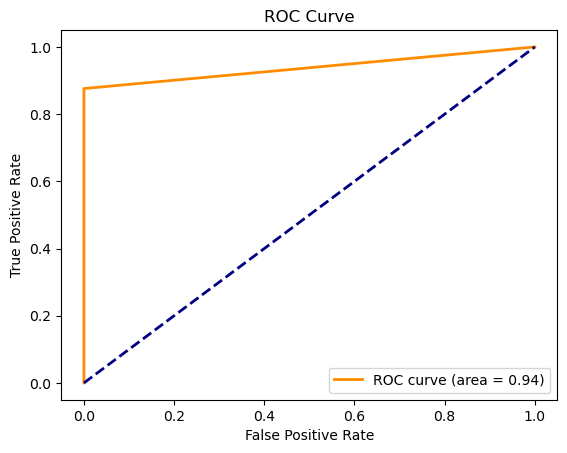

In [16]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

ID3 Decision Tree:

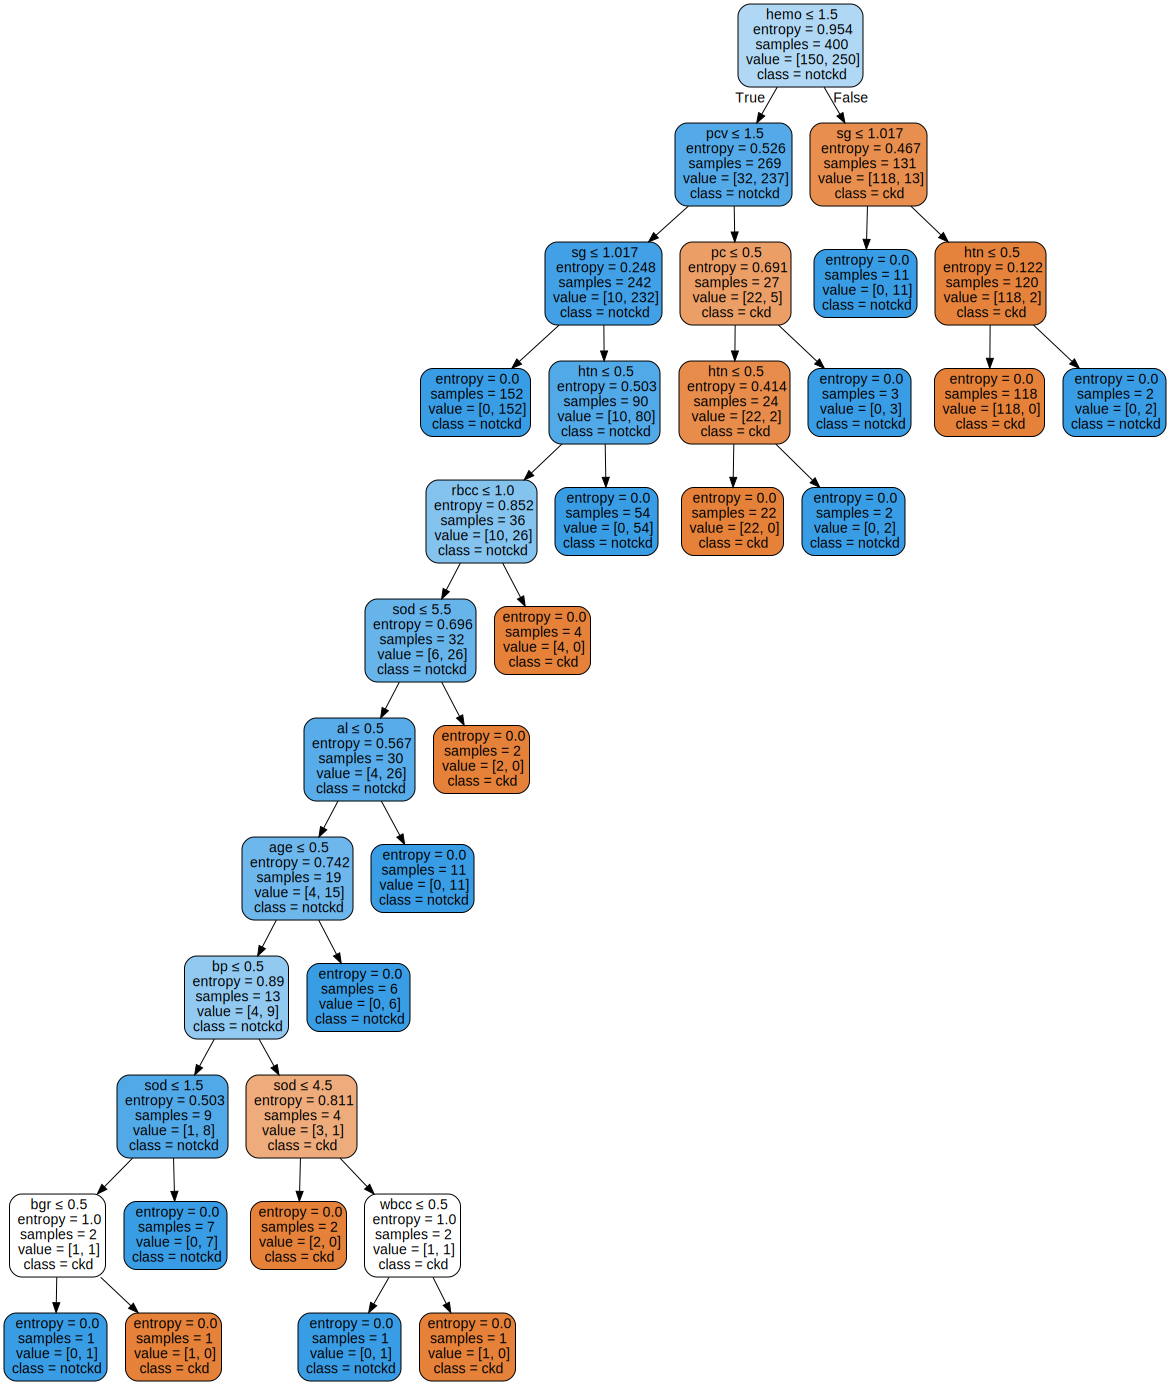

In [17]:
dot_data = export_graphviz(id3_model, out_file=None, filled=True, rounded=True, special_characters=True, feature_names=columns[:-1], class_names=['ckd', 'notckd'])
graph = graphviz.Source(dot_data)
graph.render('ID3-tree')
display(graph)

CART Decision Tree:

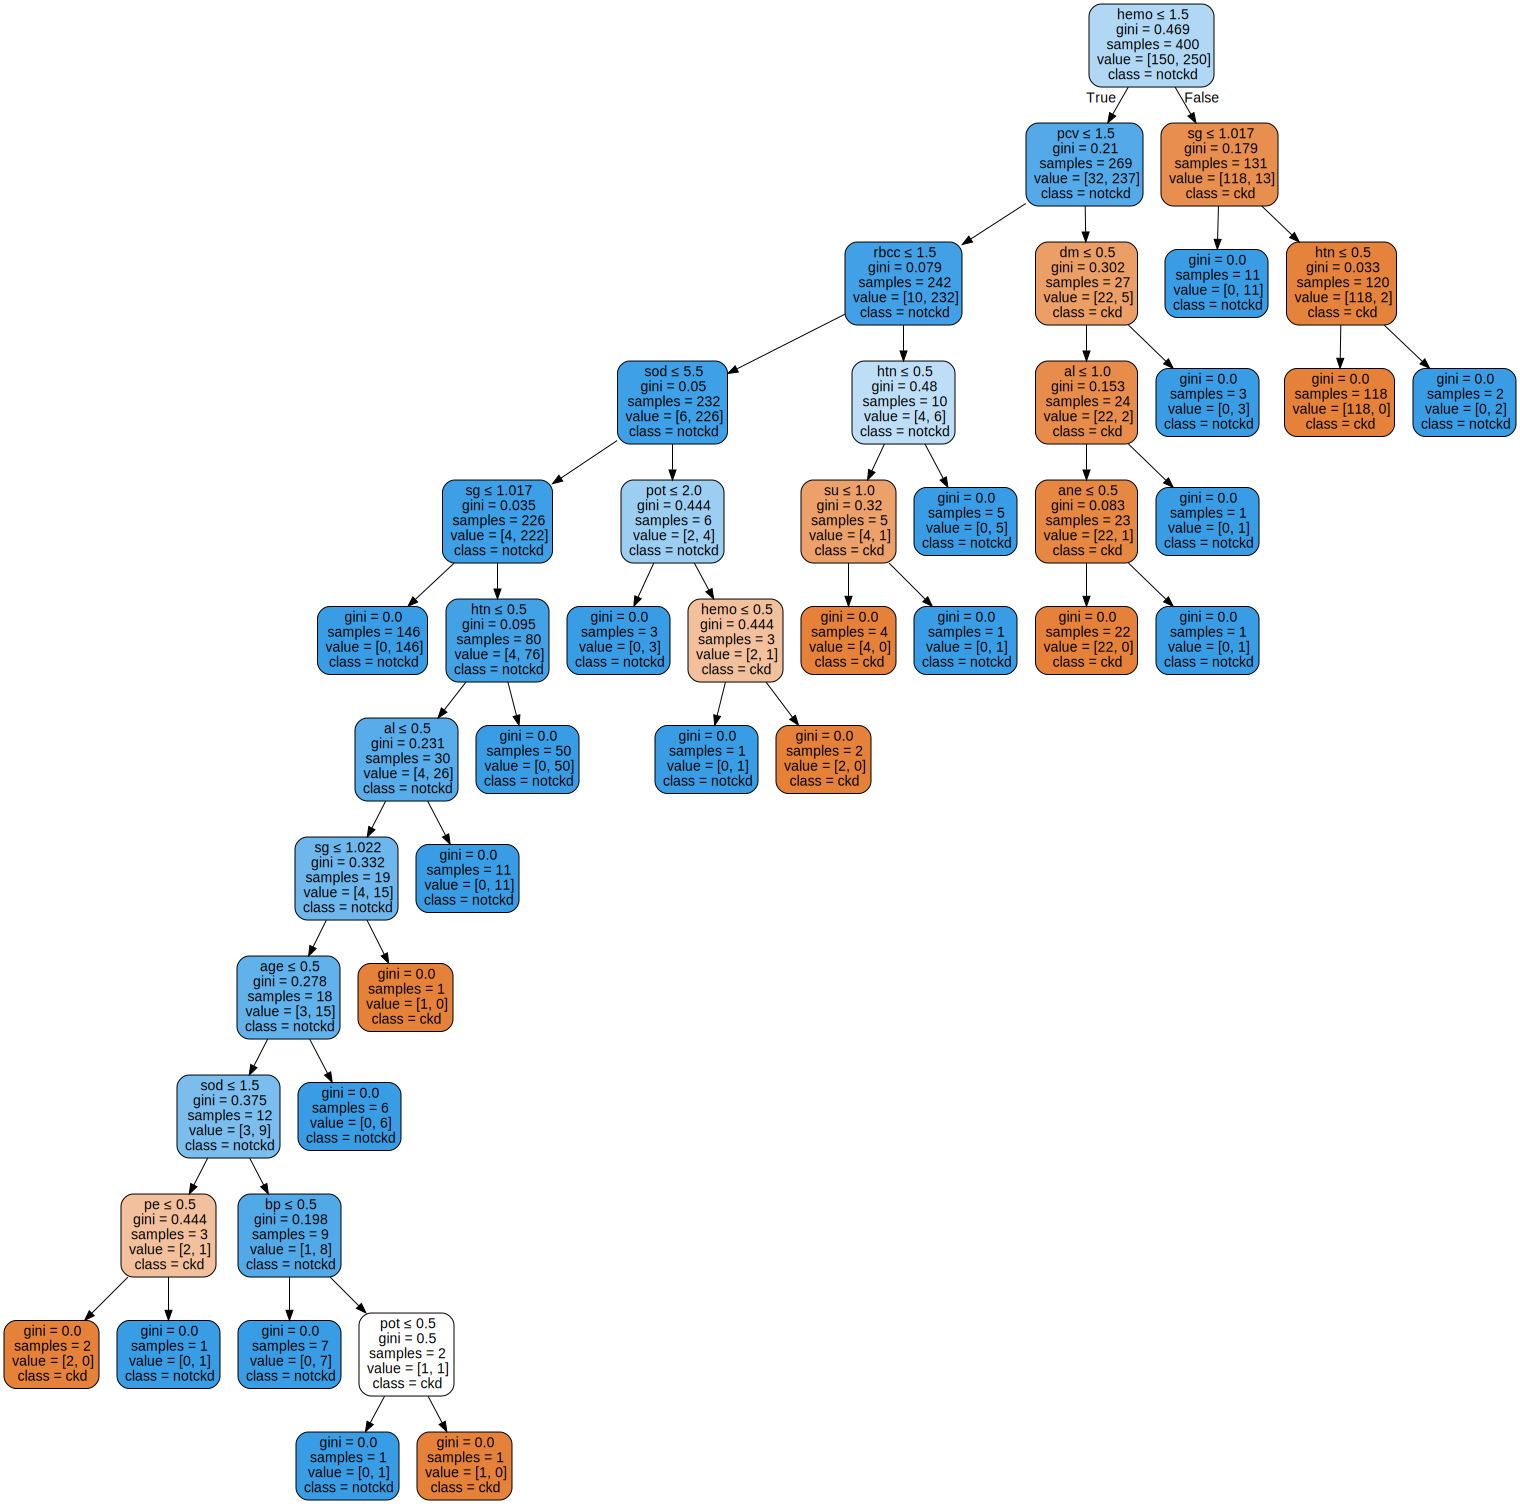

In [18]:
dot_data = export_graphviz(cart_model, out_file=None, filled=True, rounded=True, special_characters=True, feature_names=columns[:-1], class_names=['ckd', 'notckd'])
graph = graphviz.Source(dot_data)
graph.render('CART-tree')
display(graph)

## A Comperative Analysis of Potential Options for Conducting Data Mining

### Logistic Regression

A statistical model employed for forecasting a categorical class from either categorical or numerical attributes, which provides the likelihood of association with a particular class.

- **Advantages** - easy to implement and use, and conveniently presentable. Moreover, the algorithm does not require any prior assumptions about the distribution of the random variables in the feature space, and can handle both numerical and categorical values. <br>
- **Disadvantages** - the model tends to overfit/underfit if the number of examples is big/small compared to the number of features. In addition, the model is not recommended when the features are co-linear.

In [19]:
print("Logistic Regression Accuracy: ", logreg_accuracy)
print("Logistic Regression Coefficients: ", logreg_coeff)

Logistic Regression Accuracy:  0.9432946569214931
Logistic Regression Coefficients:  [[-0.13281419  0.78417721 -0.13992138  1.93669127  0.78343707  0.76505715
   1.02046221  0.11655374  0.03116259  0.82906555  0.48521819  1.71212667
  -0.52999121 -0.02832705 -2.87146726 -2.47645456  0.54610705 -1.69103193
   1.67961939  2.03783148  0.1036677  -1.39858539  1.12204881  0.84495154]]


### Information Gain based Decision Tree

A supervised learning model designed for classification tasks, which iteratively divides the data based on the features, in relation to the measure of _information gain_.

- **Constraints** - a discretization task must be done for each continuous feature.
- **Advantages** - easy to implement and use, and conveniently presentable. Moreover, the algorithm can handle noisy data and missing values, by pruning the tree.
- **Disadvantages** - the _information gain_ metric generally favors attributes with a broader spectrum of values. Moreover, the algorithm could be quite demanding in terms of computational resources.

In [20]:
print("ID3 Accuracy: ", id3_accuracy)

ID3 Accuracy:  0.9501813064459361


### Gini Index based Decision Tree (CART)

An algorithm that constructs a binary decision tree, which iteratively divides the data into two based on the features, utilizing the _Gini index_ metric, so that each split results in two subgroups that are as similar in size as feasible.

- **Advantages** - can manage both numerical and categorical data, along with missing values. Furthermore, the resulting tree is typically more concise compared to other decision tree algorithms.
- **Disadvantages** - the _Gini index_ measure tends to prefer features with larger range of values, and the running time is longer, compared to other decision tree algorithms.

In [21]:
print("CART Accuracy: ", cart_accuracy)

CART Accuracy:  0.9618231051766472


### Random Forest

A classifier that combines the outcomes of numerous decision trees to attain the best possible results.

- **Advantages** - can manage high-dimensional, extensive datasets, including those with missing values. It also has the ability to decrease the data's variance, thereby preventing overfitting, by averaging the predictions generated by the various trees it constructs.
- **Disadvantages** - an algorithm that operates slowly, particularly on extensive datasets, and it has a tendency to favor features with a greater number of degrees. Additionally, this classifier is not as easily representable as a solitary decision tree.

## Describe the Stages of Data Preperations

### Handling Missing Values

Given that the dataset contains 24 features, any example with more than a third (8) of its features missing will be removed. If not, the missing values will be replaced with the **mean** (for numerical values) or the **mode** (for categorical values).

### Data Transformation

Transform all categorical values into nominal variables based on their value (for instance, 'yes' will be assigned the value $1$, etc.), and convert these values into `float` type (real numbers).
Implement transformations in accordance with the selected classification algorithm:

For the `Logistic Regression` algorithm, normalize the nominal data using `min-max` method, so that the new range will be $[0,1]$.

However, for the `Random Forest` algorithm, discretize the numerical values by splitting the data to intervals with equal frequency, so that each values group will get equal representation.

Furthermore, we'll consider the possibility of errors in the data entry process, such as an extra '0' added, or a missed decimal point, etc. Hence, for features with a high standard deviation or abnormal minimum/maximum values relative to the mean, we'll manually adjust their values.

## Classification

### Select Two Techniques for Data Classification

The chosen techniques are `Logistic Regression` and `Random Forest`.

#### Logistic Regression

A classification algorithm that estimates the likelihoods of association with a certain prediction class, in our scenario - the presence of chronic kidney disease. The algorithm examines the relationships between one or more independent variables (we'll operate under the assumption that the features are indeed independent). The model employs a logistic function to scrutinize the conditional probabilities among the features, implying it computes the probability of class membership given the values of a particular feature.

#### Random Forest

An ensemble algorithm that combines the outcomes achieved by executing numerous decision trees, and delivers an optimal classification based on the majority vote from the results of the decision trees. In the majority of instances, the classification obtained is more precise than that derived from a single decision tree.

### Describe the Steps of the Chosen Techniques

For both techniques, I employed _10-fold cross-validation_ and _bootstrap sampling_ to obtain more precise predictions. Each method was trained using the same examples, but the examples were processed differently for each algorithm.

#### Logistic Regression

The algorithm seeks a set of weights that would minimize prediction error. After data cleansing, we'll normalize it using the `min-max` method to ensure all values fall within the $[0,1]$ range, preventing any value from having an undue influence. The model will be trained using iterative methods, like `Gradient Descent`, to find the optimal weights that minimize the in-sample error, defined as the least squares loss (_l2-loss_). Additionally, we'll employ regularization to prevent overfitting.

#### Random Forest

The data will be discretized through binning into intervals of equal frequency, ensuring each feature value gets equal representation among the other values. I've determined that in each algorithm run, 100 decision trees will be generated, and each split will depend on at most the square root of the total feature count. The splitting criterion will be grounded on the _Gini index_.

In [22]:
def random_forest_model(X, y, k): # random forest model
    accuracy = []
    sum = 0
    randfor = RandomForestClassifier(bootstrap=False)
    
    for i in range(k): # k-fold cross validation
        X_train, y_train, indices = bootstrap_sample(X, y, int(len(X) * 0.8)) # bootstrap sampling for 80% of the data
        X_test, y_test = [], []
        score = 0 # accuracy score
        
        for j in range(len(indices)):
            if indices[j] == 0:
                X_test.append(X[j])
                y_test.append(y[j])
                
        randfor = randfor.fit(X_train, y_train)
        y_pred = randfor.predict(X_test)
        length = len(y_pred)
        
        for j in range(length):
            if y_pred[j] == y_test[j]: # if prediction is correct
                score += 1
        
        accuracy.append(score / length)

    for i in range(len(accuracy)):
        sum += accuracy[i]
    accuracy = sum / len(accuracy) # average accuracy
    randfor = randfor.fit(X, y) # fit the model with all the data
    importance = randfor.feature_importances_
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    
    print("Detailed accuracy: \n", detailed_accuracy(y_test, y_pred, fpr, tpr, auc))
    
    return randfor, accuracy, importance

In [23]:
randfor_model, randfor_accuracy, randfor_importance = random_forest_model(df_x_dt, df_y_dt, k)

Detailed accuracy: 
     TP FP Precision    Recall F-Measure       AUC   Class  Accuracy Error Rate
1  128  3  0.977099  0.984615  0.980843  0.970692     ckd                     
2   54  2  0.964286  0.947368  0.980843  0.970692  notckd                     
3                                                  Total:  0.973262   0.026738


In [24]:
print("Random Forest Accuracy: ", randfor_accuracy)

Random Forest Accuracy:  0.9866954236409681


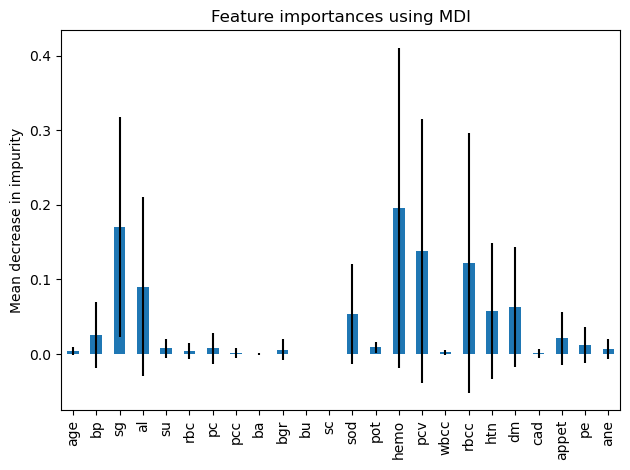

In [25]:
feature_names = [f"{col}" for col in columns if col != 'class']
forest_importances = pd.Series(randfor_importance, index=feature_names)   
std = np.std([tree.feature_importances_ for tree in randfor_model.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

plt.show()

## Bayesian and Observational Learning

### Describe and Analyze Your Choice

The selected algorithm is `Naïve-Bayes` due to its relative simplicity when compared to the `Bayesian network`. The latter accounts for all feature interdependencies, while `Naïve-Bayes` operates under the assumption of feature independence, yet still delivers commendable results in practice. A `Bayesian network` requires a larger database to infer feature dependencies. Given that the preprocessed database only contains 378 examples, the `Naïve-Bayes` algorithm, which can handle smaller databases, is the preferred choice. Furthermore, as the `Bayesian network` necessitates numerous computations, opting for `Naïve-Bayes` provides a simpler algorithm with significantly faster training and execution times.


However, `Naïve-Bayes` performance could be compromised if there are correlated features, prompting us to carry out dimensionality reduction (for instance, by using the `PCA` algorithm) to obtain a dataset with reduced correlation.

The algorithm computes the conditional probabilities of each feature given the classification class, and then, for any new unseen example, it calculates the product of the relevant conditional probabilities for each class. The class that yields the highest probability becomes the final classification of the algorithm.

### Describe and Analyze the Task Using K-NN Algorithm

`K-NN` is a classification algorithm that views the data as points within a space, the dimension of which equals the number of features.

This algorithm doesn't necessitate training as each example is computed independently of others, but in relation to its $k$ nearest examples, based on a certain distance function. Hence, the algorithm is straightforward to implement and time-efficient. To execute it, all that's required is to compute the distances between all points, then identify the nearest neighbors and classify the new example based on them.

Given that it necessitates these calculations, we can deduce that for larger databases or a high number of features, it won't be as effective, as it calculates the distance from all points for each new classification. Additionally, the values of each feature need to be normalized to prevent the algorithm from favoring features with higher values.

To classify a new example, the algorithm computes the distance between the new point and all other points in the database, selecting the $k$ closest points. Following this, the classification is immediate and is determined by the majority vote among all the neighbors.

### Choose One Method and Explain Your Choice

The chosen algorithm is `Naïve-Bayes`, primarily because it's generally faster to train and classify than `KNN`. This is because it calculates probabilities under the assumption of independence, unlike `KNN` which necessitates storing and computing the distances of all examples for the classification task. Moreover, the assumption of independence simplifies the model as it pertains to a smaller set of hypotheses, only those where the features are independent, unlike `KNN` which doesn't make any simplifying assumptions. Additionally, the `Naïve-Bayes` algorithm is easier to interpret than `KNN` since the model's decisions are based solely on conditional probabilities between each feature and class, making it clear how a result is obtained. Conversely, `KNN` requires calculating distance and then classifies based on majority vote, making the classification task less intuitive to understand.

In [26]:
def naive_bayes_model(X, y, k): # naive bayes model
    accuracy = []
    sum = 0
    nb = GaussianNB()
    
    for i in range(k): # k-fold cross validation
        X_train, y_train, indices = bootstrap_sample(X, y, int(len(X) * 0.8)) # bootstrap sampling for 80% of the data
        X_test, y_test = [], []
        score = 0 # accuracy score
        
        for j in range(len(indices)):
            if indices[j] == 0:
                X_test.append(X[j])
                y_test.append(y[j])
        
        nb.fit(X_train, y_train)
        y_pred = nb.predict(X_test)
        length = len(y_pred)
        
        for j in range(length):
            if y_pred[j] == y_test[j]: # if prediction is correct
                score += 1
        
        accuracy.append(score / length)
        
    for i in range(len(accuracy)):
        sum += accuracy[i]
    accuracy = sum / len(accuracy) # average accuracy
    nb.fit(X, y) # fit the model with all the data
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    
    print("Detailed accuracy: \n", detailed_accuracy(y_test, y_pred, fpr, tpr, auc))
    
    return nb, accuracy  

### Run and Report the Results of the Algorithm

I utilized `Python` to execute the algorithm. Analogous to the classification conducted using the previous algorithms, I implemented _k-fold cross-validation_ with $k=10$. In each iteration, we carry out _bootstrap sampling_ to obtain the training set, while the remainder forms the test set.

In [27]:
nb_model, nb_accuracy = naive_bayes_model(df_x_dt, df_y_dt, k)
print("Naive Bayes Accuracy: ", nb_accuracy)

Detailed accuracy: 
     TP FP Precision    Recall F-Measure       AUC   Class  Accuracy Error Rate
1  110  5  0.956522       1.0  0.977778  0.978261     ckd                     
2   62  0       1.0  0.925373  0.977778  0.978261  notckd                     
3                                                  Total:  0.971751   0.028249
Naive Bayes Accuracy:  0.959979658287881


## Cluster Analysis

### Define Quality Measures for Clustering

In order to evaluate the quality of a cluster created by a cluster analysis algorithm, we'll use the next measurements:

- **Intra-cluster Distance** - we aim for all elements within a cluster to be as similar as possible. This is achieved by calculating the sum of squared distances between each pair of points within the cluster, with the goal of minimizing this sum.
- **Inter-cluster Distance** - we aim for each cluster to be as distinct as possible from other clusters. We perform the same calculation as before, but this time we aim for the sum to be maximal.
- **Homogeneity** - we desire each cluster to contain elements that belong to the same class.
- **Completeness** - we want examples that are classified to the same class to belong to the same cluster.
- **V-measure** - the harmonic mean between _homogeneity_ and _completeness_, which describes the trade-off between these two.
- **ARI Measurement** - assesses the similarity between _actual_ and _predicted_ classifications, and the _degree of randomness_ in classifying new examples.
- **AMI Measurement** - evaluates the mutual information between the _actual_ and _predicted_ classifications, similar to _ARI measurement_.
- **Silhouette** - examines the degree to which an example matches the cluster to which it belongs based on the distance from points within the cluster and points in nearby clusters.

### Choose One Method for Cluster Analysis

The selected algorithm is `DBScan`. This is a density-based clustering algorithm that operates under the assumption that clusters are high-density areas separated by lower-density areas. As it identifies clusters based on density rather than distance, it can detect clusters of arbitrary shapes, not necessarily elliptical. Furthermore, it doesn't make assumptions about the data distribution. This robust algorithm is not sensitive to outliers or noise. However, it is computationally expensive as it iterates through all points and calculates distances between them for every _core point_. Given that our database doesn't contain a large number of observations, we can overlook the computational cost of the algorithm and, in return, achieve more accurate clusters.

In [28]:
def dbscan_model(X, y, k): # DBSCAN model  
    accuracy = []
    sum = 0
    dbscan = DBSCAN(eps=0.5, min_samples=6)
    
    for i in range(k): # k-fold cross validation
        X_train, y_train, indices = bootstrap_sample(X, y, int(len(X) * 0.8)) # bootstrap sampling for 80% of the data
        X_test, y_test = [], []
        score = 0 # accuracy score
        
        for j in range(len(indices)):
            if indices[j] == 0:
                X_test.append(X[j])
                y_test.append(y[j])
    
        dbscan.fit(X_train, y_train)
        y_pred = dbscan.fit_predict(X_test)
        length = len(y_pred)
        
        for j in range(length):
            if y_pred[j] == y_test[j]: # if prediction is correct
                score += 1
        
        accuracy.append(score / length)
        
    for i in range(len(accuracy)):
        sum += accuracy[i]
    accuracy = sum / len(accuracy) # average accuracy
    dbscan.fit(X, y) # fit the model with all the data
    labels = dbscan.labels_ # cluster labels
    
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) # number of clusters
    n_noise_ = list(labels).count(-1) # number of noise points
    homogenity = homogeneity_score(y, labels) # homogenity score
    completeness = completeness_score(y, labels) # completeness score
    v_measure = v_measure_score(y, labels) # v-measure score
    adjusted_rand = adjusted_rand_score(y, labels) # adjusted rand score
    adjusted_mutual_info = adjusted_mutual_info_score(y, labels) # adjusted mutual info score
    silhouette = silhouette_score(X, labels) # silhouette score
    
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print('Homogenity: %0.3f' % homogenity)
    print('Completeness: %0.3f' % completeness)
    print('V-measure: %0.3f' % v_measure)
    print('Adjusted Rand Index: %0.3f' % adjusted_rand)
    print('Adjusted Mutual Information: %0.3f' % adjusted_mutual_info)
    print('Silhouette Coefficient: %0.3f' % silhouette)
    
    return dbscan, accuracy

### Describe the Cluster Analysis Steps for the Chosen Approach

To run `DBScan`, we need to preprocess the data. This involves handling missing values (either by completion or deletion), converting values to numerical values (even though the algorithm can handle categorical values), and normalizing the data so that features like _Age_ don't have undue importance in the classification task. To achieve clearer, easily interpretable clusters, we'll apply a dimensionality reduction algorithm, such as `Principal Component Analysis` (PCA). The `PCA` algorithm essentially projects the data into a lower-dimensional vector space to maximize variance. It does this by calculating the _eigenvalues_ of each feature and retaining the $n$ largest ones, where $n$ is the desired dimension.

Given that we are working with the optimized database, there's no need for further data processing as the data already meet our requirements, with the exception of dimensionality reduction.

The `DBScan` algorithm doesn't necessitate the user to provide the expected number of clusters. However, it does use a parameter $\varepsilon$ that defines the neighborhood radius of each point, and a parameter _MinPts_, which, as the name implies, is the minimum number of points required in the $\varepsilon$-neighborhood of a point.

The algorithm categorizes points into three groups - **core** points, **border** points, and **noise** points, characterized by the following features:

- A point $p$ is a **core point** if there are at least _MinPts_ points within its $\varepsilon$-neighborhood.
- If the distance between points $p$ and $q$, where $p$ is a core point, is less than $\varepsilon$, we say that $q$ is _directly reachable_ from $p$.
- If there's a path between $p$ and $q$ where each pair of consecutive points are directly reachable, we say that $q$ is _reachable_ from $p$.
- Any point that isn't reachable is considered an **outlier** or **noise point**.

The algorithm operates as follows:

1. For each point, identify all points within its $\varepsilon$-neighborhood.
2. If the number of points found exceeds _MinPts_, mark this point as a **core point**.
3. For each core point, find all its reachable neighbors.
4. Continue this process until there are no more core points to check.

### Run and Report the Results of the Algorithm

I utilized Python to execute the algorithm. The necessary parameters are defined as _MinPts_=6, $\varepsilon$=0.5, and we apply `PCA` to reduce the dimensions from 24 to 2 for visibility purposes.

In [29]:
pca = PCA(n_components=2) # PCA
df_x_pca = pca.fit_transform(df_x_lr) # dimensionality reduction to 2D for visualization
dbs_model, dbs_accuracy = dbscan_model(df_x_pca, df_y_lr, k)
print("DBSCAN Accuracy: ", dbs_accuracy)

Estimated number of clusters: 1
Estimated number of noise points: 62
Homogenity: 0.123
Completeness: 0.188
V-measure: 0.149
Adjusted Rand Index: -0.028
Adjusted Mutual Information: 0.147
Silhouette Coefficient: 0.590
DBSCAN Accuracy:  0.36373979897755004


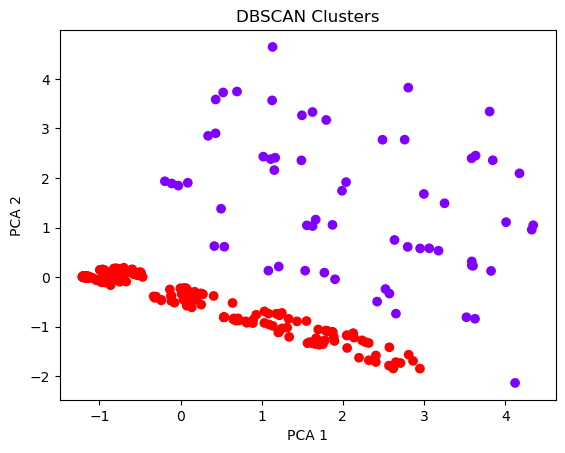

In [30]:
plt.scatter(df_x_pca[:, 0], df_x_pca[:, 1], c=dbs_model.labels_, cmap='rainbow')
plt.title('DBSCAN Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

## Artificial Neural Networks

### Define the Network Architecture

The neural network is defined as follows. The network will consist of three types of layers:

- **Input layer** - contains 24 neurons, corresponding to the data being taken from a 24-dimensional space.
- **Hidden layers** - these are situated between the input and output layers. After a process of trial and error, we choose _two_ hidden layers, each containing 10 neurons.
- **Output layer** - this is the final layer in the network and contains two neurons, corresponding to the number of classes in our task.

The network is defined as a _feed-forward_, _fully-connected_ network, meaning that the direction of the network is strictly forward, from the input layer to the output layer, and each neuron in a layer is connected to all neurons in the subsequent layer.

The activation function will be `ReLU`.

The loss function will be `Cross-entropy`, with optimization performed using `Stochastic Gradient Descent` (SGD). The loss function is defined as follows:

$H_p (q) = -1/N \cdot \sum_{n=1}^N (y_n \cdot log (p(y_n)) + (1-y_n) \cdot log (1-p(y_n)))$


where $p(y_n)$ is the predicted probability of the $n$-th example belonging to class $y_n$, and $y_n$ is the actual class of the $n$th example.

In [31]:
def mean_squared_error(Y_test, Y_pred): # mean squared error
    length = len(Y_test)
    sum = 0
    
    for i in range(length):
        sum += (Y_test[i] - Y_pred[i]) ** 2
    
    return sum / length

In [32]:
def neural_network_model(X, y, k): # neural network model
    accuracy = []
    train_accuracies = []
    val_accuracies = []
    sum = 0
    nn = MLPClassifier(activation='relu', solver='sgd', alpha=1e-5, hidden_layer_sizes=[10], random_state=1, max_iter=1000, early_stopping=False)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 80% training, 20% testing
    
    for i in range(k): # k-fold cross validation
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2) # 80% training, 20% validation   
        
        nn.fit(X_train, y_train)
        y_pred = nn.predict(X_test)
        
        score = nn.score(X_val, y_val)
        accuracy.append(score)
        
        train_accuracy = accuracy_score(y_train, nn.predict(X_train))
        train_accuracies.append(train_accuracy)
        
        val_accuracy = accuracy_score(y_val, nn.predict(X_val))
        val_accuracies.append(val_accuracy)
        
    for i in range(len(accuracy)):
        sum += accuracy[i]
    accuracy = sum / len(accuracy) # average accuracy
    
    nn.fit(X_train, y_train)
    y_pred = nn.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    
    plt.figure(figsize=(10, 3))
    
    sub1 = plt.subplot(1, 2, 1)
    sub1.plot(nn.loss_curve_)
    sub1.title.set_text('Neural Network Training Set Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Training'], loc='upper left')
    
    sub2 = plt.subplot(1, 2, 2)
    sub2.plot(train_accuracies, label='Training Accuracy')
    sub2.plot(val_accuracies, label='Validation Accuracy')
    plt.legend()
    
    plt.show()    
    
    
    print("Detailed accuracy: \n", detailed_accuracy(y_test, y_pred, fpr, tpr, auc))
    print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
    
    nn.fit(X, y) # fit the model with all the data
    return nn, accuracy

### Define the Optimization Parameters

The optimization parameters include the batch size, learning rate, regularization parameters, and optimization algorithm. As previously stated, we've chosen `SGD` as the optimization algorithm, with each batch being of size 100. The regularization parameter will remain at $α=0.0001$, and the learning rate will be $l=0.001$, in line with the default values in the `SKLearn` library.

### Run and Report the Results of the Algorithm

I utilized Python to run the network. Initially, we split the dataset into a training set ($80%$) and a test set ($20%$). We then perform _k-fold cross-validation_, where in each fold we further divide the training set into a training set ($80%$) and a validation set ($20%$). This allows us to measure the classifier's accuracy.

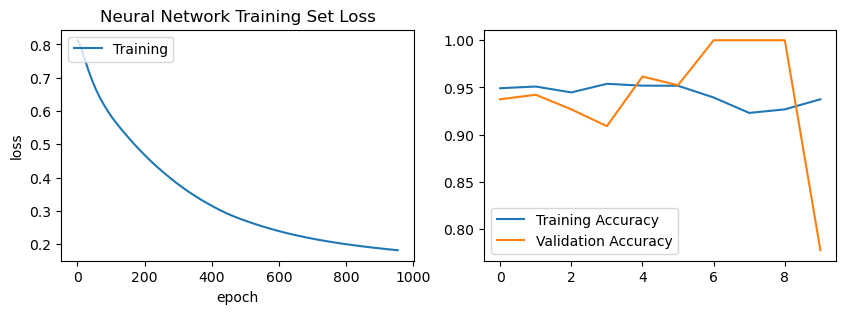

Detailed accuracy: 
    TP FP Precision    Recall F-Measure       AUC   Class Accuracy Error Rate
1  41  5  0.891304       1.0  0.942529  0.945652     ckd                    
2  34  0       1.0  0.871795  0.942529  0.945652  notckd                    
3                                                 Total:   0.9375     0.0625
Mean squared error: 0.06
Neural Network Accuracy:  0.9407425061388477


In [33]:
nn_model, nn_accuracy = neural_network_model(df_x_lr, df_y_lr, k)
print("Neural Network Accuracy: ", nn_accuracy)